<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [101]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [102]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'https://drive.google.com/uc?id=1VLVgb3fD02XrF2V5OruKvQTOT91juXcs&export=download'
        output = 'songs_dataset.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [103]:
# Posibles bandas
os.listdir("./songs_dataset/")

['bjork.txt',
 'jimi-hendrix.txt',
 'nirvana.txt',
 'adele.txt',
 'lady-gaga.txt',
 'bruce-springsteen.txt',
 'dolly-parton.txt',
 'lorde.txt',
 'dickinson.txt',
 'britney-spears.txt',
 'leonard-cohen.txt',
 'cake.txt',
 'janisjoplin.txt',
 'bob-dylan.txt',
 'ludacris.txt',
 'alicia-keys.txt',
 'beatles.txt',
 'al-green.txt',
 'prince.txt',
 'radiohead.txt',
 'notorious_big.txt',
 'disney.txt',
 'nursery_rhymes.txt',
 'amy-winehouse.txt',
 'notorious-big.txt',
 'blink-182.txt',
 'bieber.txt',
 'joni-mitchell.txt',
 'nicki-minaj.txt',
 'missy-elliott.txt',
 'r-kelly.txt',
 'michael-jackson.txt',
 'nickelback.txt',
 'lil-wayne.txt',
 'lin-manuel-miranda.txt',
 'dj-khaled.txt',
 'kanye-west.txt',
 'dr-seuss.txt',
 'bob-marley.txt',
 'johnny-cash.txt',
 'kanye.txt',
 'paul-simon.txt',
 'rihanna.txt',
 'bruno-mars.txt',
 'eminem.txt',
 'drake.txt',
 'Lil_Wayne.txt',
 'Kanye_West.txt',
 'patti-smith.txt']

In [104]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/nirvana.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0
0,"Load up on guns, bring your friends"
1,It's fun to lose and to pretend
2,She's over-bored and self-assured
3,"Oh no, I know a dirty word Hello, hello, hello..."
4,"Hello, hello, hello, how low"


In [105]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1985


### Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [106]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [107]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Load up on guns, bring your friends'

In [108]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['load', 'up', 'on', 'guns', 'bring', 'your', 'friends']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [109]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [110]:
# Demos un vistazo
sentence_tokens[:2]

[['load', 'up', 'on', 'guns', 'bring', 'your', 'friends'],
 ["it's", 'fun', 'to', 'lose', 'and', 'to', 'pretend']]

In [111]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [112]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['load', 'up', 'on', 'guns'],
 ['up', 'on', 'guns', 'bring'],
 ['on', 'guns', 'bring', 'your']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [113]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [114]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[5, 3, 1, 2], [3, 1, 2, 4], [1, 2, 4, 6]]

In [115]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

3


In [116]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

6


In [117]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'on': 1, 'guns': 2, 'up': 3, 'bring': 4, 'load': 5, 'your': 6}


In [118]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'up': 2, 'guns': 3, 'on': 3, 'load': 1, 'bring': 2, 'your': 1})


### Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [119]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                   Load up on guns, bring your friends
1                       It's fun to lose and to pretend
2                     She's over-bored and self-assured
3     Oh no, I know a dirty word Hello, hello, hello...
4                          Hello, hello, hello, how low
5                          Hello, hello, hello, how low
6     Hello, hello, hello With the lights out, it's ...
7                         Here we are now, entertain us
8                          I feel stupid and contagious
9                         Here we are now, entertain us
10          A mulatto, an albino, a mosquito, my libido
11                Yeah, hey I'm worse at what I do best
12                     And for this gift I feel blessed
13                     Our little group has always been
14    And always will until the end Hello, hello, he...
15                         Hello, hello, hello, how low
Name: 0, dtype: object

In [120]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Load up on guns, bring your friends It\'s fun to lose and to pretend She\'s over-bored and self-assured Oh no, I know a dirty word Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello With the lights out, it\'s less dangerous Here we are now, entertain us I feel stupid and contagious Here we are now, entertain us A mulatto, an albino, a mosquito, my libido Yeah, hey I\'m worse at what I do best And for this gift I feel blessed Our little group has always been And always will until the end Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello With the lights out, it\'s less dangerous Here we are now, entertain us I feel stupid and contagious Here we are now, entertain us A mulatto, an albino, a mosquito, my libido Yeah, hey, yeh And I forget just why I taste Oh yeah, I guess it makes me smile I found it hard, it\'s hard to find Oh well, whatever, never mind Hello, hello, hello, ho

In [121]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['load',
 'up',
 'on',
 'guns',
 'bring',
 'your',
 'friends',
 "it's",
 'fun',
 'to',
 'lose',
 'and',
 'to',
 'pretend',
 "she's",
 'over',
 'bored',
 'and',
 'self',
 'assured']

In [122]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 12346


In [123]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [124]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['load', 'up', 'on', 'guns'],
 ['up', 'on', 'guns', 'bring'],
 ['on', 'guns', 'bring', 'your'],
 ['guns', 'bring', 'your', 'friends'],
 ['bring', 'your', 'friends', "it's"],
 ['your', 'friends', "it's", 'fun'],
 ['friends', "it's", 'fun', 'to'],
 ["it's", 'fun', 'to', 'lose'],
 ['fun', 'to', 'lose', 'and'],
 ['to', 'lose', 'and', 'to'],
 ['lose', 'and', 'to', 'pretend'],
 ['and', 'to', 'pretend', "she's"],
 ['to', 'pretend', "she's", 'over'],
 ['pretend', "she's", 'over', 'bored'],
 ["she's", 'over', 'bored', 'and'],
 ['over', 'bored', 'and', 'self'],
 ['bored', 'and', 'self', 'assured'],
 ['and', 'self', 'assured', 'oh'],
 ['self', 'assured', 'oh', 'no'],
 ['assured', 'oh', 'no', 'i']]

In [125]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[617, 74, 26, 472],
 [74, 26, 472, 382],
 [26, 472, 382, 18],
 [472, 382, 18, 220],
 [382, 18, 220, 33],
 [18, 220, 33, 272],
 [220, 33, 272, 5],
 [33, 272, 5, 244],
 [272, 5, 244, 7],
 [5, 244, 7, 5],
 [244, 7, 5, 342],
 [7, 5, 342, 343],
 [5, 342, 343, 221],
 [342, 343, 221, 383],
 [343, 221, 383, 7],
 [221, 383, 7, 384],
 [383, 7, 384, 473],
 [7, 384, 473, 124],
 [384, 473, 124, 15],
 [473, 124, 15, 1]]

In [126]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 12342


### Input y target

In [127]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [128]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [129]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [130]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(12342, 3)
(12342,)


In [131]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'the',
 3: 'a',
 4: 'you',
 5: 'to',
 6: 'me',
 7: 'and',
 8: "don't",
 9: 'in',
 10: 'my',
 11: "i'm",
 12: 'it',
 13: 'of',
 14: 'hello',
 15: 'no',
 16: 'is',
 17: 'have',
 18: 'your',
 19: 'know',
 20: "you're",
 21: 'for',
 22: 'girl',
 23: 'she',
 24: 'what',
 25: 'they',
 26: 'on',
 27: 'with',
 28: 'like',
 29: 'not',
 30: 'way',
 31: 'we',
 32: 'was',
 33: "it's",
 34: 'when',
 35: 'away',
 36: 'yeah',
 37: 'this',
 38: 'as',
 39: 'expect',
 40: 'do',
 41: 'be',
 42: 'never',
 43: 'so',
 44: 'if',
 45: 'out',
 46: 'love',
 47: 'more',
 48: 'all',
 49: 'right',
 50: 'think',
 51: 'will',
 52: 'just',
 53: 'are',
 54: 'said',
 55: 'feel',
 56: 'one',
 57: 'gun',
 58: 'can',
 59: "ain't",
 60: 'dive',
 61: 'find',
 62: 'that',
 63: 'sun',
 64: 'had',
 65: 'here',
 66: 'now',
 67: 'little',
 68: 'her',
 69: 'would',
 70: 'night',
 71: 'go',
 72: 'gonna',
 73: 'take',
 74: 'up',
 75: 'how',
 76: 'hey',
 77: "i've",
 78: 'he',
 79: 'ah',
 80: 'heart',
 81: 'but',
 82: '

In [132]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1479

In [133]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [134]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(12342, 1479)

### Entrenar el modelo

In [135]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [136]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1479

In [137]:
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128))) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy

epochs = 120
learning_rate = 0.001
decay_rate = learning_rate / epochs

sgd = Adam(lr=learning_rate, decay=decay_rate)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3, 5)              7400      
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 3, 256)            137216    
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_12 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_13 (Dense)             (None, 1479)              48807     
Total params: 595,887
Trainable params: 595,887
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [138]:
hist = model.fit(x_data, y_data, epochs=epochs, validation_split=0.2)

Epoch 1/120
309/309 [==============================] - 13s 22ms/step - loss: 6.1110 - accuracy: 0.0383 - val_loss: 6.7030 - val_accuracy: 0.0312
Epoch 2/120
309/309 [==============================] - 5s 16ms/step - loss: 5.6411 - accuracy: 0.0436 - val_loss: 6.9303 - val_accuracy: 0.0211
Epoch 3/120
309/309 [==============================] - 5s 16ms/step - loss: 5.4997 - accuracy: 0.0443 - val_loss: 7.0153 - val_accuracy: 0.0284
Epoch 4/120
309/309 [==============================] - 5s 16ms/step - loss: 5.2047 - accuracy: 0.0600 - val_loss: 7.4492 - val_accuracy: 0.0397
Epoch 5/120
309/309 [==============================] - 5s 16ms/step - loss: 4.9535 - accuracy: 0.0877 - val_loss: 7.7008 - val_accuracy: 0.0466
Epoch 6/120
309/309 [==============================] - 5s 16ms/step - loss: 4.7489 - accuracy: 0.1015 - val_loss: 7.9878 - val_accuracy: 0.0454
Epoch 7/120
309/309 [==============================] - 5s 16ms/step - loss: 4.5858 - accuracy: 0.1143 - val_loss: 8.2363 - val_accuracy

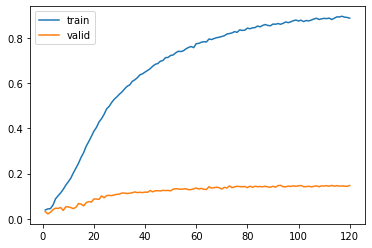

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Generación de secuencias nuevas

In [140]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [141]:
input_text='I need to'
generate_seq(model, tok, input_text, max_length=3, n_words=3)

'I need to yours and my'

In [142]:
input_text='we both know'
generate_seq(model, tok, input_text, max_length=3, n_words=2)

'we both know it lights'

In [143]:
input_text='With the lights'
generate_seq(model, tok, input_text, max_length=3, n_words=1)

'With the lights if'

In [144]:
input_text='Hello, hello, hello'
generate_seq(model, tok, input_text, max_length=3, n_words=2)

'Hello, hello, hello up i'

In [145]:
input_text='She should have'
generate_seq(model, tok, input_text, max_length=3, n_words=3)

'She should have the scaled the'

### Conclusiones

Se amplio el modelo estudiado en clase, agregando capas bidireccionales y aumentando las epocas de entrenamiento. Sin embargo debido al tamanno limitado del vocabulario no se logra un accuracy aceptable.